In [2]:
#gradient descent implementation

def median(prob,x_vals) :
    return x_vals[prob.cumsum()>=0.5][0]

def sign(x) :
    return 2*(x>0)-1

def grad_descent(y, th0 = 0, g0 = 0.7) :
    n = y.shape[0]
    th_t = th0
    th_bar = 0
    th_hat = []
    th_hat.append(th0)
    for i in xrange(n) :
        th_t = th_t + (i+1)**(-g0)*sign(y[i]-th_t)
        #th_t = th_t + g0**i * sign(y[i]-th_t)
        th_bar += th_t
        th_hat.append(th_bar / (i+1.))
    return th_hat
    

In [7]:
#Bayesian estimator implementation
from scipy.special import erf
from scipy.stats import norm
import numpy as np

def Qfunc(x) :
    return 0.5*(1-scipy.special.erf(x/np.sqrt(2)))

def Phi(x) :
    return norm.cdf(x)

def phi(x) :
    return norm.pdf(x)

def bayes_adaptive(y, Amin, Amax, th_prior = None, 
                   g0 = 1, xx = None, eps = 1e-3) :

    n = y.shape[0]
    
    if th_prior == None : 
        #uniform prior
        dx = (Amax-Amin)*eps/np.sqrt(n)
        xx = np.arange(Amin,Amax,dx)
        th_prior = (xx<Amax)*(xx>Amin)*1.0/(Amax-Amin)*dx
        #least favorable
        #th_prior = (np.exp(-(xx-Amax) ** 2 * 10.) + np.exp(-(xx+Amin) ** 2 * 10. ))
    
    th_all = []
    th_all.append((xx*th_prior).sum()) #zero information estimation
    for i in xrange(n) :
        #th_hat = median(th_prior,xx)
        th_prior = th_prior/th_prior.sum()
        M = 2*((y[i]-th_hat)>0)-1
        th_prior = th_prior*g0**(i+1)*Qfunc(M*(th_hat-xx))
        th_hat = (xx*th_prior).sum()
        th_all.append(th_hat)
    return th_all
    
def binary_entropy(x) :
    return -x * np.log2(x)-(1-x) * np.log2(1-x)

In [4]:
#Sigma-Delta Estimator

def sigma_delta(y, v0 = 0,gain = 1) :
    n = y.shape[0]
    qs = []
    v = v0
    q = 0
    th_hat = np.zeros_like(y)
    for i in xrange(n) :
        v = v - q + y[i]
        m = (2 * (v>0) - 1)
        q = gain * m
        qs.append(q)
        th_hat[i] = np.mean(qs)
    return th_hat

In [5]:
import scipy 
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

<H1> Evaluations </H1>

In [135]:
th = Amin + (Amax-Amin)*np.random.rand()# uniform prior over (Amin,Amax)
z = np.random.randn(n)
y = z + th

In [193]:
#generate data
nMonte = 1000

n = 1000

Amax = 3
Amin = -3

err_var_grad = np.zeros(n+1)
err_grad = np.zeros(n+1)
err_var_bayes = np.zeros(n+1)
err_bayes = np.zeros(n+1)
err_var_sdm = np.zeros(n+1)
err_sdm = np.zeros(n+1)
err_var_smp = np.zeros(n+1)
err_smp = np.zeros(n+1)

for i in xrange(nMonte) :
    if i % 50 == 0 :
        print "Iteration #{}".format(i)
    th = Amin + (Amax-Amin)*np.random.rand()# uniform prior over (Amin,Amax)
    z = np.random.randn(n)
    y = z + th
    
    th_hat_grad = grad_descent(y, g0 = 0.37)
    err_grad += th-np.array(th_hat_grad)
    err_var_grad += (th-np.array(th_hat_grad))**2
    
    th_hat_bayes = bayes_adaptive(y,-Amax,Amax, g0 = 1)
    err_bayes += th-np.array(th_hat_bayes)
    err_var_bayes += (th-np.array(th_hat_bayes))**2
    
    #th_hat_sdm = sigma_delta(y,v0  = 0)
    #err_sdm += th-np.array(th_hat_sdm)
    #err_var_sdm += (th-np.array(th_hat_sdm))**2
    
    mean_hat = np.cumsum(y) / np.arange(1,n+1)
    err_smp += th-mean_hat
    err_var_smp += (th-np.array(mean_hat))**2

err_var_grad /= nMonte
err_grad /= nMonte
err_var_bayes /= nMonte
err_bayes /= nMonte    
#err_var_sdm /= nMonte
#err_sdm /= nMonte    
err_var_smp /= nMonte
err_smp /= nMonte    

print "Done!"

#np.save('err_var_grad_{}_nMonte{}'.format(n,nMonte),err_var_grad)
#np.save('err_var_bayes_{}_nMonte{}'.format(n,nMonte),err_var_bayes)
#np.save('err_var_sdm_{}_nMonte{}'.format(n,nMonte),err_var_sdm)

Iteration #0
Iteration #50
Iteration #100
Iteration #150
Iteration #200
Iteration #250
Iteration #300
Iteration #350
Iteration #400
Iteration #450
Iteration #500
Iteration #550
Iteration #600
Iteration #650
Iteration #700
Iteration #750
Iteration #800
Iteration #850
Iteration #900
Iteration #950
Done!


In [84]:
#load data
nMonte = 500
n = 600
err_var_grad = np.load('err_var_grad_{}_nMonte{}.npy'.format(n,nMonte))
#err_var_bayes = np.load('err_var_bayes_{}_nMonte{}.npy'.format(n,nMonte))
#err_var_sdm = np.load('err_var_sdm_{}_nMonte{}.npy'.format(n,nMonte))


<H2>Results Illustration</H2>

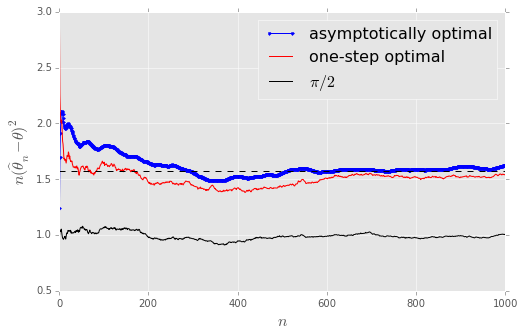

In [199]:
n_vals = np.arange(1,len(err_var_grad))

plt.figure(figsize=(8,5))
plt.plot(n_vals,n_vals*err_var_grad[1:],'.-b')
#plt.plot(n_vals,err_grad,'--b')
plt.plot(n_vals,n_vals*err_var_bayes[1:],'r')
#plt.plot(n_vals,n_vals*err_var_sdm,'g')
plt.plot(n_vals,n_vals*err_var_smp,'k')
#plt.plot(n_vals,err_bayes,'--r')
plt.xlabel(r'$n$', fontsize = 16)
plt.ylabel(r'$n(\widehat{\theta}_n-\theta)^2$', fontsize = 16)
plt.plot(n_vals,np.pi/2 * np.ones_like(n_vals),'--k')
plt.legend(['asymptotically optimal','one-step optimal',r'$\pi/2$'], loc=1, fontsize = 16)
#plt.savefig('error.png', format='png')
plt.show()

In [157]:
err_var_grad[2]*

1.3158720393173264

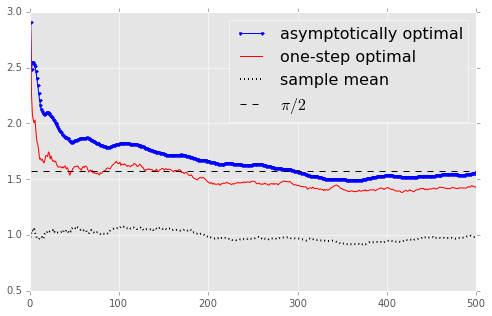

In [215]:

k1 = 0
k2 = 500 #len(err_var_grad)


n_vals = np.arange(k1+1,k2+1)

plt.figure(figsize=(8,5))
plt.plot(n_vals,n_vals*err_var_grad[k1:k2],'.-b')
#plt.plot(n_vals,err_grad,'--b')
plt.plot(n_vals,n_vals*err_var_bayes[k1+1:k2+1],'r')
plt.plot(n_vals,n_vals*err_var_smp[k1:k2],':k', linewidth = 2)
#plt.plot(n_vals,n_vals*err_var_sdm[:k],'g')
#plt.plot(n_vals,err_bayes,'--r')
#plt.xlabel(r'$n$', fontsize = 16)
#plt.ylabel(r'$n(\widehat{\theta}_n-\theta)^2$', fontsize = 16)
plt.plot(n_vals,np.pi/2 * np.ones_like(n_vals),'--k')
#plt.legend(['asymptotically optimal','one-step optimal',r'$\pi/2$'], loc=5, fontsize = 16)
#plt.legend(['SGD','Bayes',r'$\pi/2$'], loc=5, fontsize = 16)
plt.legend(['asymptotically optimal','one-step optimal','sample mean',r'$\pi/2$'], loc=1, fontsize = 16)
plt.savefig('one_bit_adpative.png', format='png')
plt.show()

In [213]:
err_var_bayes[1]

2.9125717745801789

n = 25 : 
Error sgd = 1.409033002 (mean = 0.0359002425115)
Error Bayes = 1.54822669161 (mean = 0.0408731933387)
Error Unconstained = 0.868966102339 (mean = 0.0145946526561)


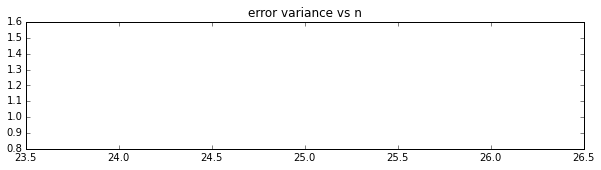

In [27]:
#Gradient descent for one-bit estimation
#Shows asymptotic normality

var_sgd = []
var_bayes = []
var_sigmaDelta = []
var_unc = []
n_vals = np.sort(np.random.choice(range(50,100),3,replace=False))
n_vals = [4, 8, 16, 32, 64, 128, 256, 350, 512]
n_vals = [25]
nMonte = 100

Amax = 2.5
Amin = -2.5

for n in n_vals :
    
    sgd_Monte = []
    bayes_Monte = []
    sigmaDelta_Monte = []
    unc_Monte = []

    for j in xrange(nMonte) :
        #th = np.random.randn(1) #Gaussian prior
        th = Amin + (Amax-Amin)*np.random.rand()# uniform prior over (Amin,Amax)
        z = np.random.randn(n)
        y = z + th

        th_hat_sgd = grad_descent(y, g0 = 0.25)[-1]
        th_hat_bayes = bayes_adaptive(y,-Amax,Amax, g0 = 1)
        #th_hat_sigmaDelta = sigma_delta(y,v0 = 0,b = 2)
        th_hat_unconstrained = y.mean()
        sgd_Monte.append((th-th_hat_sgd))
        bayes_Monte.append((th-th_hat_bayes))
        #sigmaDelta_Monte.append(np.sqrt(n)*(th-th_hat_sigmaDelta))
        unc_Monte.append((th-th_hat_unconstrained))

    print 'n = {} : '.format(n)
    print 'Error sgd = {} (mean = {})'.format(n*np.array(sgd_Monte).var(),np.array(sgd_Monte).mean())
    print 'Error Bayes = {} (mean = {})'.format(n*np.array(bayes_Monte).var(),np.array(bayes_Monte).mean())
    #print 'Error SigmaDelta = {}'.format((np.array(sigmaDelta_Monte)**2).mean())
    print 'Error Unconstained = {} (mean = {})'.format(n*np.array(unc_Monte).var(),np.array(unc_Monte).mean())
    var_sgd.append(n*np.array(sgd_Monte).var())
    var_bayes.append(n*np.array(bayes_Monte).var())
    #var_sigmaDelta.append((np.array(sigmaDelta_Monte)**2).mean())
    var_unc.append(n*np.array(unc_Monte).var())
    

#plt.subplot(2, 1, 1)
#plt.title('sgd')
#plt.hist(sgd_Monte, 50, normed=1, facecolor='green', alpha=0.75)
#plt.subplot(2, 1, 2)
#plt.title('Bayes')
#plt.hist(bayes_Monte, 50, normed=1, facecolor='green', alpha=0.75)

    
plt.subplot(2, 1, 1)
plt.title('error variance vs n')
plt.plot(n_vals,var_sgd, color = 'green')
plt.plot(n_vals,var_bayes, color = 'red')
#plt.plot(n_vals,var_sigmaDelta, color = 'cyan')
plt.plot(n_vals,var_unc, color = 'black')
plt.plot(n_vals,np.zeros_like(n_vals)*0 + np.pi/2 , color = 'black', linestyle='--')
#plt.hist(sgd_Monte, 50, normed=1, facecolor='green', alpha=0.75)
#plt.subplot(2, 1, 2)
#plt.title('Bayes')
#plt.hist(bayes_Monte, 50, normed=1, facecolor='green', alpha=0.75)

plt.show()



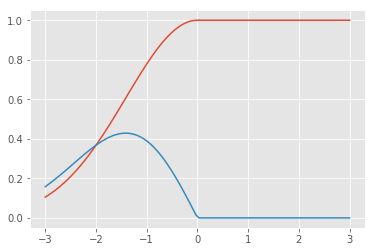

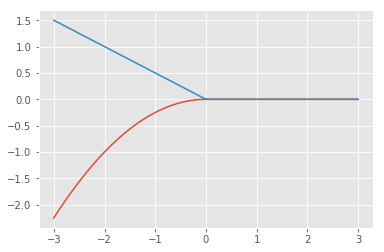

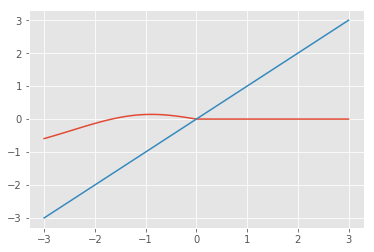

In [45]:
def g(x) :
    return -0.25*x**2 * (x<0)

def gp(x) :
    return -0.5*x * (x<0)

F = lambda x: np.exp(g(x))
f = lambda x: np.exp(g(x)) * gp(x)


xx = np.linspace(-3,3,100)

plt.plot(xx,F(xx))
plt.plot(xx,f(xx))
plt.plot

plt.show()


plt.plot(xx,g(xx))
plt.plot(xx,gp(xx))

plt.show()


def eta(x) :
    return f(x) * (F(x)-0.5) / (F(x)*F(-x))


plt.plot(xx,eta(xx))
plt.plot(xx,xx)

plt.show()


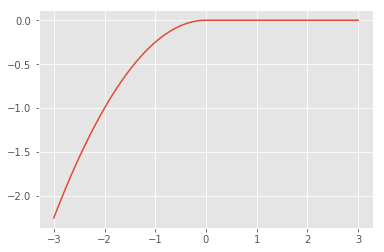

In [44]:
plt.plot(xx,g(xx))

To check: expectation and variance of th_bar given the previous estimate